# Inteligenta Artificiala - Tema 1 Laborator 2
# Bucur Robert-Adrian
### Grupa 10LF381

In [346]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, List

## Data reading

In [347]:
# incarcarea datelor

# data source: http://archive.ics.uci.edu/ml/datasets/Condition+Based+Maintenance+of+Naval+Propulsion+Plants
file = 'data.txt'
data_df = pd.read_csv(file, sep=r'\s+', header=None)
data = data_df.values

In [348]:
# se sterge penultima coloana

data = np.delete(data, -2, axis=1)      # scrieti cod
print(data.shape)
assert data.shape == (11934, 17)

(11934, 17)


## Input processing

In [349]:
# Functie pentru separarea datelor de intrare de cele de iesire

def get_input_output(mat: np.array) -> Tuple[np.array, np.array]:
    """Separa partea de intrare (variabile independente) de cea de iesire 
    (variabila dependenta).
    
    :param mat: np.array de forma (m, n). Fiecare linie este un caz 
    inregistrat, adica un vector de intrare. Primele n-1 coloane sunt valori 
    de intrare in model, ultima coloana este valoarea de iesire asociata 
    (ground truth).
    
    :return: un tuplu cu: matrice de (m, n-1) continand intrarile 
    (o linie = un vector de intrare); un vector coloana cu m linii continand
    valorile de iesire asociate intrarilor.
    """
    m, n = mat.shape
    X = mat[:, :-1]                 # scrieti cod
    y = mat[:, -1].reshape(m,1)     # scrieti cod
    assert np.alltrue(X == mat[:, :-1])
    assert np.alltrue(y[:, -1] == mat[:, -1])
    return X, y

In [350]:
# separa matricea cu vectorii de intrare si vectorul coloana cu iesirile asociate

X, y = get_input_output(data)       # scrieti cod

In [351]:
# Functie pentru scalarea datelor in intervalul [0, 1]. 
# Scalele se calculeaza pe baza datelor furnizate

def scale_matrix(mat: np.array) -> np.array:
    """Preia o matrice cu valori reale si scaleaza toate coloanele in 
    intervalul [0, 1]. Coloanele constante vor fi transformate in 1.
    
    :param mat: matrice de forma (m, n)
    :return: matrice cu valori scalate in [0, 1]
    """
    
    # calculeaza pe ce indecsi minimele si maximele difera. 
    # Doar pe acestea se va face scalare. Coloanele pentru care minimele si 
    # maximele sunt egale au valori constante si vor fi umplute automat cu 1.
    min_cols, max_cols = np.amin(mat, axis=0), np.amax(mat, axis=0)     # scrieti codpentru a determina minimele si maximele 
    # de pe fiecare coloana a lui mat
    different_min_max = min_cols != max_cols    # scrieti cod pentru a determina pe ce coloane 
    # minimele si maximele difera
    result = np.ones_like(mat)
    result[:, different_min_max] = (mat[:,different_min_max] - min_cols[different_min_max]) / (max_cols[different_min_max] - min_cols[different_min_max])# scrieti cod pentru scalarea datelor folosind min_cols, max_cols
    assert result.shape == mat.shape
    assert np.alltrue(np.min(result, axis=0) >= 0)
    assert np.alltrue(np.max(result, axis=0) <= 1)
    return result, min_cols, max_cols

In [352]:
# Functie pentru scalarea datelor. 
# Scalele sunt furnizate, de regula calculate pe baza datelor din setul 
# de antrenare

def scale_matrix_with_known_minmax(mat: np.array, min_cols: np.array, max_cols: np.array) -> np.array:
    """Preia o matrice  :param mat: si efectueaza scalarea valorilor in 
    intervalul [0, 1] folosind valori de min si max pe fiecare coloana 
    precalculate si date prin parametrii :param min_cols:, :param max_cols:.
    
    :param mat: matricea de (m, n) care trebuie scalata.
    :param min_cols: minime pe coloane, precalculate
    :param max_cols: maxime pe coloane, precalculate
    :return: matrice de (m, n) cu valori scalate.
    """
    # calculeaza pe ce indecsi minimele si maximele difera. 
    # Doar pe acestea se va face scalare. Coloanele pentru care minimele si 
    # maximele sunt egale au valori constante si vor fi umplute automat cu 1.
    different_min_max = min_cols != max_cols    # scrieti cod pentru a determina pe ce coloane difera 
    # minimele si maximele (coloane cu valori necosntante)
    result = np.ones_like(mat)
    result[:, different_min_max] = (mat[:,different_min_max] - min_cols[different_min_max]) / (max_cols[different_min_max] - min_cols[different_min_max])       # scrieti cod care sa scaleze datele 
    # folosind parametrii min_cols si max_cols dati
    assert result.shape == mat.shape
    return result

In [353]:
# scaleaza matricele

X, min_cols, max_cols = scale_matrix(X)     # scrieti cod pentru a scala X intre 0 si 1 # aici min_cols si max_cols nu vor fi de fapt folosite
y, _, _ = scale_matrix(y)       # scrieti cod pentru a scala coloana y in [0, 1]

In [354]:
# calculeaza matricea de design: coloana de 1 adaugata in fata datelor originare

def design_matrix(mat: np.array) -> np.array:
    """Preia o matrice de forma (m, n) si returneaza o matrice de forma 
    (m, n+1), in care prima coloana este 1, iar ultimele n coloane sunt 
    coloanele lui :param mat:.
    
    :param mat: matrice de forma (m, n)
    :return: matrice de forma (m, n+1), cu prima coloana plina cu 1, ultimele 
    n coloane sunt cele din :param mat:
    """
    m, n = mat.shape
    result = np.insert(mat, 0, 1, axis=1)       # scrieti cod
    assert result.shape == (m, n+1)
    assert np.alltrue(result[:, 0] == 1)
    assert np.alltrue(result[:, 1:] == mat)
    return result

In [355]:
# calculeaza matricea de design: vechea matrice la care se adauga pe prima
# pozitie coloana cu 1
X = design_matrix(X)        # scrieti cod

## Linear regression with stochastic gradient descent

### Model implementation

In [356]:
# Functie care implementeaza modelul de regresie liniara

def h(X: np.array, w: np.array) -> np.array:
    """Pentru un model liniar specificat prin parametrii w si un set de date 
    de intrare X produce valorile estimate de model: 
    y_hat[i] = X[i, 0] * w[0] + X[i, 1] * w[1] + ...  
   
   :param X: valori de intrare, structurate ca np.array de forma (m, n)
   :param w: vector de ponderi, de forma (n, 1)
   :return: vector cu valori de iesire estimate, de forma (n, 1). 
    """
    assert w.shape == (X.shape[1], 1)
    assert X.shape[1] == w.shape[0]
    y_hat = np.dot(X, w)                            # scrieti cod; pentru punctaj maxim, vectorizat
    assert y_hat.shape == (X.shape[0], 1)
    return y_hat

### MSE function

In [357]:
# Implementare de eroare patratica medie; a nu se confunda cu functia de eroare

def mean_squared_error(y: np.array, y_hat: np.array) -> float:
    """Functie de eroare patratica medie.
    
    :param y: vector coloana de m elemente, continand valorile de iesire reale 
    (ground truth)
    :param y_hat': vector coloana de m elemente, continand valorile de iesire
    estimate.
    :return: eroarea patratica medie.
    """
    result = (np.square(np.subtract(y_hat, y))).mean()        # scrieti cod
    return result

### Cost function

In [358]:
# Functia de eroare

def J(X:np.array, w:np.array, y:np.array, lmbda: float = 0) -> float:
    """Calculeaza valoarea functiei de eroare pentru intrarea curenta :param X:, 
    estimarea produsa de model folosind ponderile :param w: si iesirea corecta
    :param y: (ground truth).
    
    :param X: matrice de valori de intrare pentru care modelul de regresie 
    liniara produce estimari. Are forma (m, n)
    :param w: vector coloana de ponderi, definind coeficientii modelului de 
    regresie liniara. Are forma (n, 1).
    :param y: vector coloana de valori de iesire cunoscute (ground truth). 
    Are forma (n, 1).
    :param lmda: coeficientul de penalizare L2
    :return: jumatate din mean squared error plus penalizarea L2
    """
    assert w.shape == (X.shape[1], 1)
    assert y.shape == (X.shape[0], 1)
    assert lmbda >= 0
    m = X.shape[0]
    y_hat = h(X, w)                                 # scrieti cod
    assert y_hat.shape == (X.shape[0], 1)
    term_squared_error = mean_squared_error(y, y_hat) / 2 # scrieti cod
    l2_error = lmbda * np.sum(w ** 2)       # scrieti cod
    return term_squared_error + l2_error 

### Stochastic gradient descent implementation

In [359]:
# Calcul de gradient. gradientul se va folosi in actualizarea ponderilor. 

def gradient(X:np.array, w:np.array, y:np.array, lmbda: float = 0) -> np.array:
    """Calculeaza gradientul functiei de eroare
    
    :param X: matrice de valori de intrare pentru care modelul de regresie 
    liniara produce estimari. Are forma (m, n)
    :param w: vector coloana de ponderi, definind coeficientii modelului de 
    regresie liniara. Are forma (n, 1).
    :param y: vector coloana de valori de iesire cunoscute (ground truth). 
    Are forma (n, 1).
    :param lmda: coeficientul de penalizare L2
    :return: vector gradient
    """
    assert w.shape == (X.shape[1], 1)
    assert y.shape == (X.shape[0], 1)
    assert lmbda >= 0
    m, _ = X.shape
    y_hat = h(X, w)             # scrieti cod
    grad = np.dot(np.transpose(X),y_hat - y) / m  # scrieti cod vectorizat, daca vreti sa rulati in timp rezonabil :)
    grad[1:, ] += lmbda * np.sum(w ** 2)     # scrieti cod pentru a include si gradientul pentru termenul L2
    assert grad.shape == w.shape
    return grad

In [360]:
# Implementarea algoritmului de antrenare

def train(X:np.array, y:np.array, max_iters:int = 100000, alpha:float = 0.01, lmbda: float = 0.01) -> Tuple[np.array, List[float]]:
    """Aplica algoritmul de instruire cu gradient. 
    
    :param X: matrice de valori de intrare pentru care modelul de regresie 
    liniara produce estimari. Are forma (m, n)
    :param y: vector coloana de valori de iesire cunoscute (ground truth). 
    Are forma (n, 1).
    :param alpha: rata de invatare
    :param lmda: coeficientul de penalizare L2
    :return: tuplu continand ponderile modelului rezultate dupa instruire, lista de erori pe setul de antrenare
    """
    m, n = X.shape
    assert y.shape == (m, 1)
    assert X.shape[0] == y.shape[0]
    w = np.zeros((X.shape[1], 1))       # scrieti cod pentru initializare ponderi
    losses = [None] * max_iters
    for i in range(max_iters):
        # calculeaza si adauga loss-ul in lista
        # calculeaza gradientul si actualizaeaza ponderile w
        loss = J(X,w,y,lmbda)       # scrieti cod
        losses[i] = loss
        grad = gradient(X, w, y, lmbda)     # scrieti cod
        w -= alpha * grad       # scrieti cod pentru actualizare de ponderi folosind gradientul
    return w, losses

In [361]:
# calcul ponderi si valorile functiei de cost

w, losses = train(X, y, max_iters=10000, alpha=0.01, lmbda=0.0)

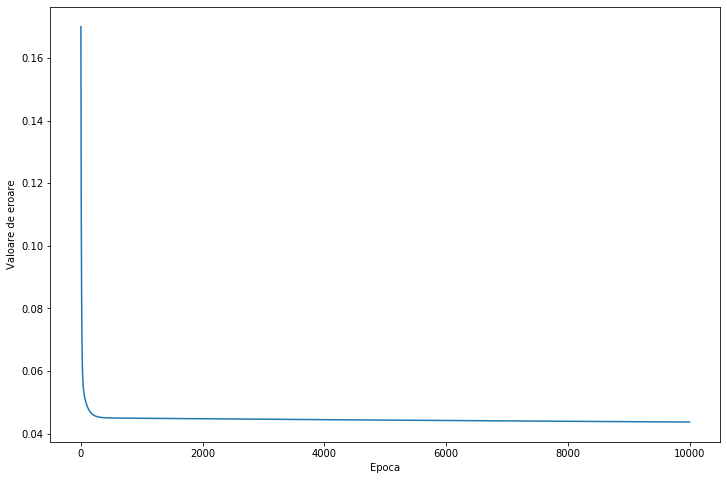

In [362]:
# desenarea curbei de cost pe setul de antrenare

plt.figure(figsize=(12, 8))
plt.xlabel('Epoca')
plt.ylabel('Valoare de eroare')
plt.plot(losses)

In [363]:
# Obtine valorile estimate de model, calculeaza eroarea intre estimare si 
# ground truth.

# estimare facuta de model
y_hat = h(X, w)    # scrieti cod
# mean squared error pe setul de antrenare
error_sgd = mean_squared_error(y, y_hat)    # scrieti cod

print('Eroarea determinata prin algoritmul stochastic gradient descent:', error_sgd)
print('Vectorul de ponderi:', w[:, 0])

Eroarea determinata prin algoritmul stochastic gradient descent: 0.08739965229029954
Vectorul de ponderi: [ 0.1796497   0.01224359  0.01065195  0.06239308  0.03546957  0.09050731
  0.05128079  0.05128079 -0.21302308  0.1796497  -0.09669057  0.02583428
  0.1796497  -0.12060324  0.15172679 -0.06333433 -0.06943563]


### Pseudoinverse method

In [364]:
# se calculeaza w cu metoda pseudoinversei 
w_pinv = np.dot(np.linalg.pinv(X), y)       # scrieti cod pentru calcul folosinf metoda pinv din numpy

# se calculeaza estimarea data cu ponderile w_pinv
y_hat_pinv = h(X, w_pinv)                   # scrieti cod

# se calculeaza eroarea patratica medie
error_pinv= mean_squared_error(y, y_hat_pinv)    # scrieti cod

print('Eroarea determinata prin metoda pseudoinversei:', error_pinv)

Eroarea determinata prin metoda pseudoinversei: 0.008010137201200609


In [365]:
print(np.linalg.norm(gradient(X, w_pinv, y)))

1.1670051757675038e-14


In [366]:
# afiseaza ponderile determinate prin metoda pseudoinversei

print(w_pinv[:, 0])

[  0.29015495   0.39839967   5.56767682  40.06318117   5.89697855
   4.03988449 -20.25484653 -20.25484653 -18.34254684   0.29015495
   1.81835155  11.32697686   0.29015495 -37.23147039   1.22929938
  -0.88382777  25.32182337]


## Split validation

In [367]:
# imparte setul initial in 70% antrenare si 30% testare

data = np.random.permutation(data)                      # scrieti cod pentru a face o permutare aleatoare
split_percentage = 0.7
split_index = int(data.shape[0] * split_percentage)     # scrieti cod; care e linia la care se opresete setul de train
data_train = data[:split_index, :]                      # scrieti cod
data_test = data[split_index:, :]                       # scrieti cod

X_train, y_train = get_input_output(data_train)         # scrieti cod pentru a separa intrarea de iesire
X_test, y_test = get_input_output(data_test)            # scrieti cod pentru a separa intrarea de iesire

In [368]:
# scaleaza datele de intrare din setul de antrenare si obtine minimele 
# si maximele pe coloane
X_train, min_X_train, max_X_train = scale_matrix(X_train)           # scrieti cod 
# scaleaza datele de iesire din setul de antrenare si obtine minimul si 
# maximul pe coloana
y_train, min_y_train, max_y_train = scale_matrix(y_train)           # scrieti cod 

In [369]:
# scaleaza datele de intrare din setul de test, folosind minimele si maximele 
# pe coloane aflate de la X_train
# se foloseste functia scale_matrix_with_known_minmax
X_test = scale_matrix_with_known_minmax(X_test, min_X_train, max_X_train)                       # scrieti cod 

# scaleaza datele de iesire din setul de test, folosind minimul si maximul 
# pe coloana aflate de la y_train
y_test = scale_matrix_with_known_minmax(y_test, min_y_train, max_y_train)                       # scrieti cod 

In [370]:
# antreneaza linear regression pe setul de antrenare, obtine ponderile
# modelului

w_train, losses_train = train(X_train, y_train, max_iters=10000, alpha=0.01, lmbda=0.0)       # scrieti cod pentru antrenare pe X_train, y_train 
# restul parametrilor ca la apelul de antrenare de mai sus

In [371]:
# obtine estimarile date de model pe setul de testare

y_hat_test = h(X_test, w_train)         # scrieti cod 
print('MSE pentru setul de testare:', mean_squared_error(y_test, y_hat_test))

MSE pentru setul de testare: 0.08905673115415534


Text(0, 0.5, 'Diferenta intre ground truth si valoarea estimata')

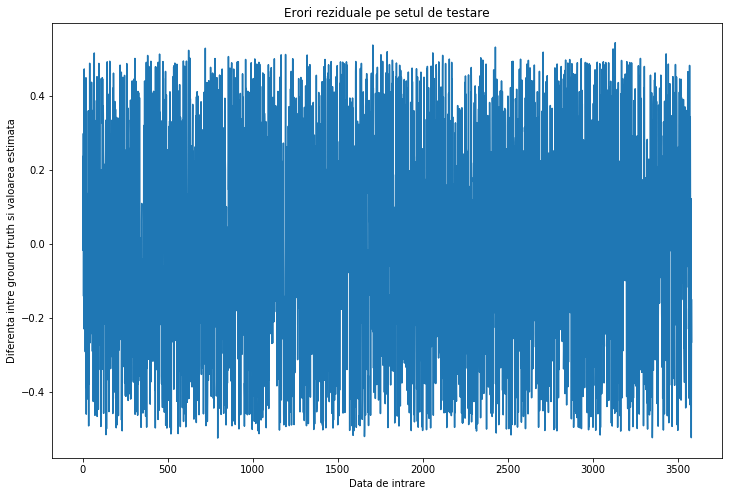

In [372]:
# reprezentarea diferentei intre ground truth si estimare pe setul de testare
plt.figure(figsize=(12, 8))
plt.title('Erori reziduale pe setul de testare')
plt.plot(y_test - y_hat_test)
plt.xlabel('Data de intrare')
plt.ylabel('Diferenta intre ground truth si valoarea estimata')

### Intrebare:
#### De ce ponderile ponderilor returnate de metoda pseudoinversei difera de valorile calculate prin metoda bazata pe gradient?
### Raspuns:
#### Deoarece in cazul metodei bazate pe gradient, la actualizarea ponderilor se ia in calcul inmultirea matriceala dintre transpusa lui X si diferenta dintre valorile estimate si ground truth, iar in cazul metodei pseudoinversei sa ia in calcul inmultirea matriceala dintre pseudoinversa lui X si ground truth.

### Intrebare:
#### Puteti explica de ce la rulari diferite se raporteaza rezultate diferite? Cum se poate face ca testele sa fie reproductibile (sa dea de fiecare data acelasi rezultat)?
### Raspuns:
#### La fiecare rulare se obtin rezultate diferite, deoarece dorim sa observam puterea algoritmului de a generaliza, iar acest lucru il realizam prin permutarea aleatoare a setului de date, folosind functia random.permutation() din numpy. Se poate face ca testele sa fie reproductibile, folosind functia numpy.random.seed() cu ajutorul careia sa resetam seed-ul la 0 de fiecare data cand se realizeaza permutarea, astfel permutarea aleatoare a datelor va fi acceasi la fiecare rulare.

### Intrebare:
#### Exista diferente de performanta pentru valori diferite ale lui α? Care este valoarea cea mai buna pe care ati gasit-o?
### Raspuns:
#### Da, exista diferente, deoarece pentru o valoarea prea mare a lui α, valoarea functiei J creste mereu sau periodic; pentru o valoare prea mica a ratei de invatare algoritmul face foarte multe iteratii pana se va opri. Astfel consider ca o valoare potrivita este 0.01.